In [1]:
import tensorflow as tf

In [2]:
if tf.config.list_physical_devices('GPU'):
    print("GPU detected.")

In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir='.',
    extract=True,
)

108512/108512 [==============================] - 12s 108us/step


'.\\datasets\\ridership.tgz'

In [4]:
import pandas as pd
from pathlib import Path

path = Path('./datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv')
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns= ['date','day','bus','rail','total']
df = df.sort_values('date').set_index('date')

df = df.drop('total',axis=1)
df = df.drop_duplicates()

df.head(4)

,day,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011


 The day_type column contains W for Weekdays, A for Saturdays, and U for
 Sundays or holiday.

In [5]:
import matplotlib.pyplot as plt

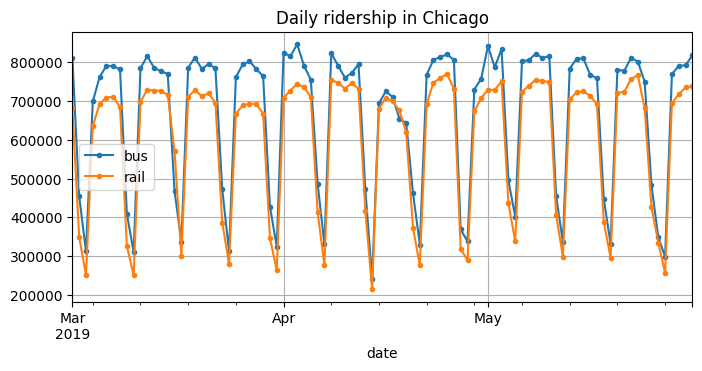

In [12]:
df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.title('Daily ridership in Chicago')
plt.show()

In [23]:
diff_7 = df[['bus','rail']].diff(7)['2019-03':'2019-05']

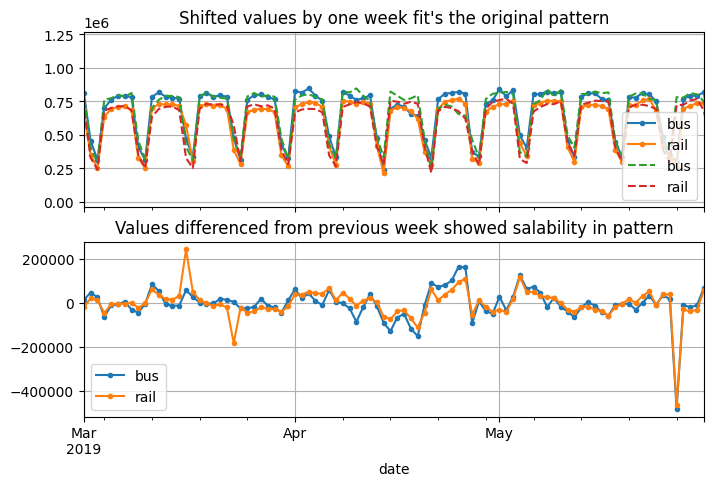

In [30]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=True, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=True, linestyle="--")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series

axs[0].set_title("Shifted values by one week fit's the original pattern")
axs[1].set_title("Values differenced from previous week showed salability in pattern")
plt.show()

comment: 

 Not too bad! Notice how closely the lagged time series track the actual time series.
 When a time series is correlated with a lagged version of itself, we say that the time
 series is autocorrelated. As you can see, most of the differences are fairly small, except
 at the end of May. Maybe there was a holiday at that time? Let’s check the day_type
 column:

In [32]:
list(df.loc["2019-05-25":"2019-05-27"]["day"])

['A', 'U', 'U']